In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Size the plot appropriately for online display
plt.rcParams['figure.figsize'] = (12.0, 10.0)

import csv
import os.path

combined = "./data/train_combined.csv"

# ammortized result from turning bytes into utf8
malware = []
not_malware = []

# create files for analysis if not present
if not os.path.isfile(combined):
    with open(combined, 'w', newline='') as combinedcsvfile:
        combinedwriter = csv.writer(combinedcsvfile)
        with open('../data/train.csv') as traincsvfile:
            trainreader = csv.reader(traincsvfile)
            with open('../data/train_label.csv') as labelcsvfile:
                next(labelcsvfile)
                labelreader = csv.reader(labelcsvfile)
                for row in labelreader:
                    arr = trainreader.__next__()
                    string = ''.join([chr(int(x)) for x in arr])
                    if row[-1] == '1':
                        malware += [string]
                    else:
                        not_malware += [string]
                    combinedwriter.writerow(arr + [row[1]])
else:
    with open(combined) as combinedcsvfile:
        combinedreader = csv.reader(combinedcsvfile)
        for row in combinedreader:
            string = ''.join([chr(int(x)) for x in row[:-1]])
            if row[-1] == '1':
                malware += [string]
            else:
                not_malware += [string]

In [2]:
print('Sample: ', malware[0])
print('malware: ', len(malware))
print('not_malware: ', len(not_malware))


$       = {Þyayayaú}xa~~a~xaRichya                        PE  L ±®jE        à   @  P      %      P   @                           Û                               7 (    p <                                                                   8                                    .text   0     @                   `.data      P     P             @  À.rsrc   <    p  0   `             @  @ìÏ:@           MSVBVM60.DLL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

According to PE stats, every PE header must have the following signature 'PE\0\0'. Let's verify that

In [3]:
pe_string = ''.join([chr(80),chr(69),chr(0),chr(0)])

def check_signature(arr):
    for res in arr:
        if pe_string not in res:
            return "Detected pe with no signature"
    return "All valid pe"

print(check_signature(not_malware))
print(check_signature(malware))
print('malware: ', len(malware))
print('not_malware: ', len(not_malware))

All valid pe
All valid pe
malware:  60117
not_malware:  53519


But can there be more than one PE signature?

In [4]:
def check_pe(arr):
    for res in arr:
        parts = res.split(pe_string)
        if len(parts) != 2:
            return '😆PE signature😆'.join(parts)
    return "All valid pe"

print(check_pe(not_malware))
print('=========================')
print(check_pe(malware))


$       {%x?DÊ?DÊ?DÊ6<Ê9DÊ¬
Ê>DÊ$ÙÊ=DÊ$Ù¼Ê2DÊ$ÙÊ8DÊ?DÊEÊ$Ù½Ê2DÊ$ÙÊ>DÊ$ÙÊ>DÊ$ÙÊ>DÊRich?DÊ        😆PE signature😆L ·
X        à !
  ,   \      -      @    f                   À     <                       x  á   \Z        <             x   °  ¤	  😆PE signature😆                           ÀQ  @            @                            .text   Ô*      ,                    `.rdata  9   @   :   0              @  @.data   è         j              @  À.rsrc   <         n              @  @.reloc  Ö	   °   
                 @  B                                                                                                                                                                                                                                                                                                                                                

$       ±uéÉÐºÉÐºÉÐº^eºÈÐºîvºÆÐºîfºÏÐºî`ºÍÐº
ßDºËÐº
ßFºÄÐºÉ

So we can't use this as a measure of malware.

There needs to be a MS_DOS_STUB which can be altered, let's see which are the uncommon ones.

In [5]:
ms_dos_stub = 'This program cannot be run in DOS mode.'
win_32_stub = 'This program must be run under Win32'
req_win_stub = 'Require Windows'

def has_stub(res):
    return ms_dos_stub in res or win_32_stub in res or req_win_stub in res

def check_pe(arr):
    count_x = 0
    count_y = 0
    for res in arr:
        parts = res.split(pe_string)
        if len(parts) != 2:
            if not has_stub(res):
                count_x += 1
        else:
            a, b = parts
            # check only before pe
            if not has_stub(a):
                count_y += 1

    print("count_x", count_x)
    print("count_y", count_y)
    
check_pe(not_malware)
print('=========================')
check_pe(malware)

count_x 5
count_y 3674
count_x 6
count_y 2262


Yikes. Malwares seem to realized they need a stub to go undetected.

Hmm, what about length of malwares vs non malwares?

In [22]:
def compare_len(arr):
    lengths = [len(x) for x in arr]
    print("Mean: ", np.mean(lengths))
    print("Median: ", np.median(lengths))
    print("Standard deviation: ", np.std(lengths))
    print("Variance: ", np.var(lengths))
    print("Min: ", min(lengths))
    print("Max: ", max(lengths))
compare_len(not_malware)
print('=========================')
compare_len(malware)

Mean:  1252.4672919897607
Median:  1024.0
Standard deviation:  1056.5791461492506
Variance:  1116359.4920774796
Min:  36
Max:  65536
Mean:  1743.2119367233895
Median:  1024.0
Standard deviation:  1422.5800687753992
Variance:  2023734.0520770196
Min:  376
Max:  98304


[8192, 65536, 12288, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192]
[(0, 21), (512, 11820), (1024, 35855), (2048, 43), (4096, 5769), (8192, 10)]


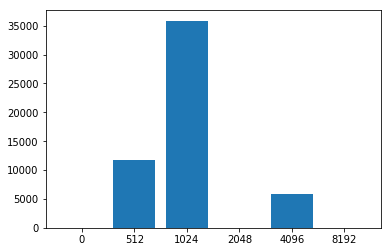

[8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 12288, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 98304, 8192, 8192, 8192, 8192, 8192, 98304, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 12288, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 12288, 8192, 8192, 8192, 8192]
[(0, 1), (512, 1504), (1024, 44786), (2048, 12), (4096, 13758), (8192, 54)]


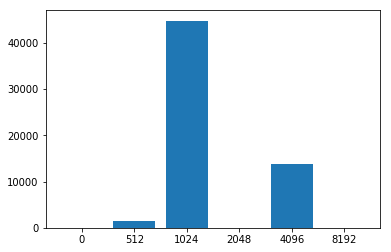

In [88]:
def compare_len(arr):
    lengths = [len(x) for x in arr]
    largest = 4096
    outliers = [x for x in lengths if x  > largest]
    print(outliers)
    x, y = np.histogram(lengths, [0, 512, 1024, 2048, 4096, 8192, 16384])
    print(list(zip(y, x)))
    plt.bar(range(len(x)), x)
    plt.xticks(range(len(x)), y[:-1])
    plt.show()

compare_len(not_malware)
print('=========================')
compare_len(malware)

In [90]:
def compare_len(arr):
    lengths = [len(x) for x in arr]
    largest = 8192
    outliers = [x for x in arr if len(x)  > largest]
    for x in outliers:
        print(x, '\n------------------------------')
compare_len(not_malware)
print('=========================')
compare_len(malware)


                          .text   2
                   `.data                          @  À.rsrc   (                       @  @.reloc  Ø­                       @  B                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      